From this notebook, you can run simulations, import the raw data from the simulations, plot results using some predefined plotting functions, and write your own functions to analyze and plot the imported raw data. Examples are below.

To simulate the case of "brickwork architecture", run **simulate_brickwork** with the parameters as documented below. This will run the simulator for a variety of instances determined by the specified parameters. The raw results of the simulation are stored in text files in the directory "results/brickwork/[run-specific name]". These text files record half-chain eigenvalues for every iteration of the effective 1D dynamics (i.e. SEBD), as well as other data. Similarly, to simulate the cluster (i.e. CHR) model, run **simulate_cluster**. Note that the brickwork simulation has additional functionality. Namely, a particular random circuit realization can be simulated multiple times. These functions return the directory where the results were stored.

After running the simulations, the data can be imported into this notebook via the **import_data** function, which returns a data structure compatible with the plotting functions.

After the data has been imported, the **plotSvL** function can be used to generate plots of half-chain entanglement entropy versus sidelength. **plotHistogram** can generate histograms of the entanglement entropy. **plotSpectrum** can be used to plot the half-chain entanglement spectrum.

Note that a minimal truncation error per bond of $10^{-16}$ is used, due to the finite numerical precision.

In [1]:
import numpy as np
import os
import re
import glob
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# L: smallest sidelength to simulate. L-1 MUST be a multiple of 8.
# k: number of sidelengths to simulate. Every sidelength of the form L+8*j for j=0...(k-1) will be simulated
# m: number of iterations of effective 1D dynamics to perform (equivalently, the other sidelength)
# numCircuits: number of distinct random circuit realizations to collect data for
# numReps: number of times to simulate each distinct circuit realization
# errorMethod: choose 1 to truncate up to bond dimension D. choose 2 to incur eps truncation error per bond
# eps: truncation error per bond (sum of discarded eigenvalues). Irrelevant if errorMethod=1
# D: bond dimension cap. Irrelevant if errorMethod=2
# 
# returns the directory where results are located
def simulate_brickwork(L, k, m, numCircuits, numReps, errorMethod=2, eps = 1e-16, D = 100000):
    if errorMethod == 2 and eps < 1e-16:
        print('Truncation error cannot be smaller than 1e-16. Setting eps=1e-16.')
        eps = 1e-16
    os.system('./brickwork.sh %d %d %d %d %d %d %.20f %d' % (L,k,m,numCircuits,numReps,errorMethod,eps,D))
    return "results/brickwork/L%d_k%d_m%d_numCircuits%d_numReps%d_method%d_err%.20f_maxB%d" % (L,k,m,numCircuits,numReps,errorMethod,eps,D)


# L_low: smallest sidelength to simulate. 
# L_high: largest sidelength to simulate. 
# m: number of iterations of effective 1D dynamics to perform (equivalently, the other sidelength)
# numCircuits: number of distinct circuit realizations to collect data for
# errorMethod: choose 1 to truncate up to bond dimension D. choose 2 to incur eps truncation error per bond
# eps: truncation error per bond (sum of discarded eigenvalues). Irrelevant if errorMethod=1
# D: bond dimension cap. Irrelevant if errorMethod=2
# increment: sidelength increment. data will be collected for L between L_low and L_high in increments of 'increment'
# 
# returns the directory where results are located
def simulate_cluster(Llow, Lhigh, m, numCircuits, errorMethod=2, eps=1e-16, D=100000, increment=1):
    if errorMethod == 2 and eps < 1e-16:
        print('Truncation error cannot be smaller than 1e-16. Setting eps=1e-16.')
        eps = 1e-16
    os.system('./cluster.sh %d %d %d %d %d %.20f %d %d' % (Llow,Lhigh,m,numCircuits,errorMethod,eps,D,increment))
    return "results/cluster/Llow%d_Lhigh%d_m%d_numCircuits%d_method%d_err%.20f_maxB%d_increment%d" % (Llow,Lhigh,m,numCircuits,errorMethod,eps,D,increment)

# For a list of eigenvalues (assumed to sum to 1), compute the k-Renyi entropy.
def computeRenyi(eigenvals,k):
    result = 0
    if k == 1:
        for e in eigenvals:
            if e != 0:
                result += -e*np.log2(e)
                
    elif k == 0:
        result = np.log2(len(eigenvals))
    else:
        for e in eigenvals:
            result += e**k
        result = np.log2(result)/(1-k)
    return result

# input directory of data files (i.e. the output of simulate_****. returns a dictionary of the form: sidelength --> list of (circuit number, repetition number, list of lists of half-chain eigenvalues (one for each iteration))
def import_data(directory):
    rep  = 1
    d = {}
    files = glob.glob(directory+"/*.txt")
    for myFile in files:
        L = int(re.search('_L([0-9]*)_',myFile).group(1))
        circuit = int(re.search('_circuit([0-9]*)_', myFile).group(1))
        if re.search('brickwork',directory):
            rep = int(re.search('_rep([0-9]*)',myFile).group(1))
            
        singVals = []
        
        f = open(myFile, "r")
        flag = False
        
        for line in f:
            line = line.strip()
            if flag == True:
                sp = re.split(',',line)
                singVals.append([float(i) for i in re.split(',',line)[:-1]])
                flag = False
            if re.search('Singular', line):
                flag = True
        f.close()
        
        if L not in d:
            d[L] = []
        
        d[L].append((circuit, rep, singVals))
        
    return d

# d is data dictionary from import_data. renyiList of list floats representing the k-Renyi entropies to compute. 
# averageNum is the number of iterations to average entanglement over (starting at the final iteration)
def plotSvL(d,renyiList,averageNum=1):
    renyiDict = {}
    listOfL = []
    for L in d.keys():
        listOfL.append(L)
    listOfL.sort()
    
    for r in renyiList:
        renyiDict[r] = [[], []]
        for L in listOfL:
            S_list = []
            for k in d[L]:
                S_temp = []
                for i in range(averageNum):
                    S_temp.append(computeRenyi(k[2][-(i+1)],r))
                S_list.append(np.average(np.array(S_temp)))
            renyiDict[r][0].append(np.average(S_list))
            renyiDict[r][1].append(np.std(S_list))
            
    listOfL.sort()
    sortedKeys = [r for r in renyiDict.keys()]
    sortedKeys.sort()
    for r in sortedKeys:
        #plt.plot(listOfL,renyiDict[r][0],label=r)
        plt.errorbar(listOfL,renyiDict[r][0],renyiDict[r][1],label=r,linestyle='-',marker='o',fmt='o')
        #plt.plot([0]+listOfL2[::2],[0]+renyiDict2[r][0][::2],label=r,linestyle='-',marker='o')
    plt.legend(loc='upper right',ncol=2)
    plt.xlabel('$L$',size='large')
    plt.ylabel('$S_k$',size='large')
    
# Plot histogram of Renyi entanglement entropies listed in renyiList. d is the output of import_data.
# Histogram is collected only for the largest simulated L.
def plotHistogram(d,renyiList,bins=None):
    renyiDict = {}
    listOfL = []
    
    for L in d.keys():
        listOfL.append(L)
    listOfL.sort()
    
    L = listOfL[-1]
    
    for r in renyiList:
        S_list = []
        for k in d[L]:
            S_list.append(computeRenyi(k[2][-1],r))
        renyiDict[r] = S_list
        plt.figure()
        plt.hist(S_list,bins)
        s = ('$S_{%s}$' % str(r))
        plt.xlabel(s,size='large')
        
# Plot the spectrum of half-chain eigenvalues for the largest simulated L, at the final iteration of the effective dynamics, for the first repretition of the first circuit. 
def plotSpectrum(d):
    listOfL = []
    for L in d.keys():
        listOfL.append(L)
    listOfL.sort()
    eigvals = d[listOfL[-1]][0][2][-1]
    eigvals.sort(reverse=True)
    
    x = np.arange(2,len(eigvals)+2)
    plt.figure()
    plt.loglog(x,eigvals,'.-')
    plt.xlabel('$i$',fontsize='large')
    plt.ylabel('$\lambda_i$',fontsize='large')

    loglogx = np.log2(np.log2(x))
    loglogy = np.array([np.log2(np.log2(1/eigvals[i-2])) for i in x])
    plt.figure()
    plt.plot(loglogx[:],loglogy[:],'.-')
    plt.xlabel('$\log \, \log (i)$',fontsize='large')
    plt.ylabel('$\log \, \log(1/\lambda_i)$',fontsize='large')

Here we simulate the brickwork architecture. The smallest sidelength is 9. We simulate 10 sidelengths (in increments of 8). For each case, we perform 50 iterations of effective 1D dynamics (i.e. iterations of SEBD). In each case, we generate 10 random circuit instances, and simulate each instance twice (for a total of 20 simulations per sidelength). We set the truncation error per bond to 1e-15. The simulation outputs the name of the directory where the output is located.

In [3]:
brickworkOutputDir = simulate_brickwork(9,10,50,10,2,2,1e-16,0)

Now, import the data generated by the simulation.

In [4]:
brickwork_data = import_data(brickworkOutputDir)

Now we plot $S_k$ versus sidelength $L$ for three half-chain Renyi entanglement entropies: $k\in \{0.5, 1, 4\}$, averaged over the final 5 iterations of the effective 1D dynamics. Error bars represent the standard deviation of this quantity across the different random circuit instaces simulated (in this case, 20 simulations per $L$, consisting of 10 distinct random circuit realizations each simulated twice). 

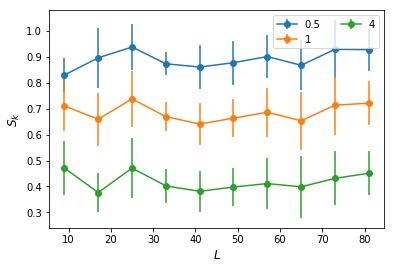

In [5]:
plotSvL(brickwork_data,[.5,1,4],5)

Plotting histograms of $S_k$ for $k \in \{0.5,7\}$. Only values for the *largest* sidelength (in this case, 81) and final iteration of 1D dynamics are used. So in this example, only 20 points are used for each histogram). In this example, we use 7 bins for each histogram.

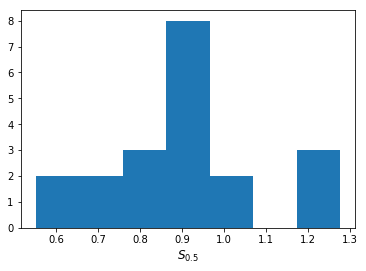

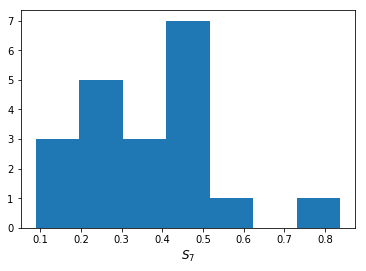

In [6]:
plotHistogram(brickwork_data,[.5,7],bins=7)

Now we plot the half-chain eigenvalue spectrum on a log-log and loglog-loglog scale for the final iteration and largest sidelength of our data. Note that the spectrum for this architecture decays extremely quickly -- we have only 7 points in this example, with the others having been truncated.

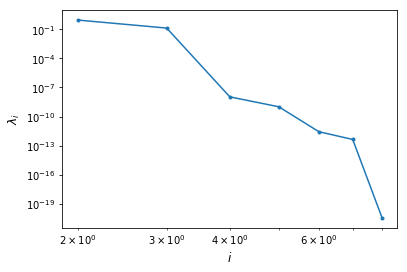

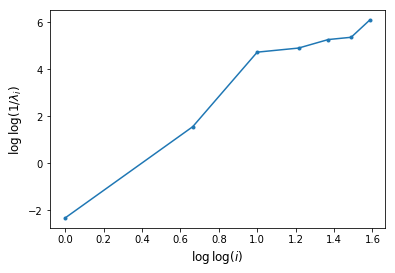

In [7]:
plotSpectrum(brickwork_data)

We now simulate the cluster (i.e. CHR) model, and generate plots of the results in a similar manner.

In [8]:
clusterOutputDir = simulate_cluster(2,20,20,10,2,1e-16,0,2)

In [9]:
cluster_data = import_data(clusterOutputDir)

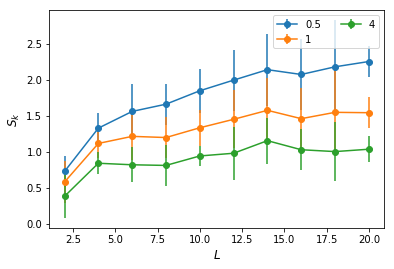

In [10]:
plotSvL(cluster_data,[.5,1,4],1)

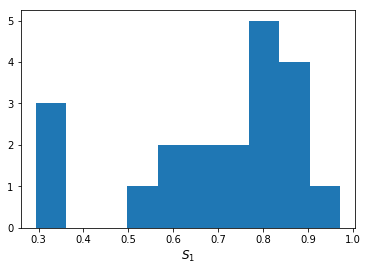

In [11]:
plotHistogram(brickwork_data,[1],bins=10)

The spectrum of Schmidt values for this model has many more points than in the case of the brickwork architecture, as the spectrum in this case decays much slower and therefore many more points are visible before dropping below the numercial precision cutoff. Note that the fact that very small singular values are being truncated throughout the process (either due to numerical precision issues or a larger user-imposed cutoff) can affect the shape of the spectrum. In particular, the values at the tail end of the visible spectrum are more likely to be distorted by the finite truncation error relative to how they would look with zero truncation error.

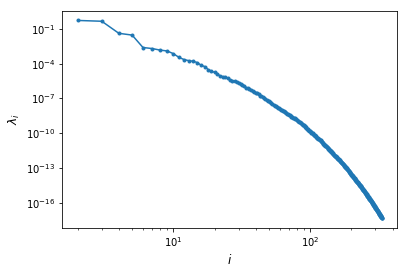

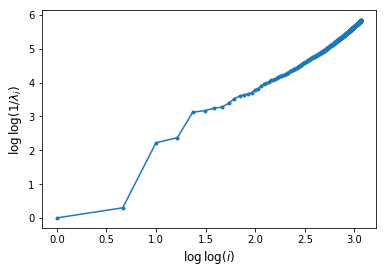

In [12]:
plotSpectrum(cluster_data)